In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes

#Let's make this notebook reproducible
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (7,4.5)
plt.rcParams["figure.dpi"] = 140

sns.set(style="ticks")
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

In [6]:
df1 = pd.read_csv('olist_orders_dataset.csv')
df2 = pd.read_csv('olist_customers_dataset.csv')
df3 = pd.read_csv('olist_order_payments_dataset.csv')

cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders = df1[cols]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

# too few
cols = ['order_id', 'payment_value']
payment = df3[cols]
payment = payment.set_index('order_id')
payment.drop_duplicates(inplace=True)

cols = ['customer_id', 'customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

elog = pd.concat([orders,customers], axis=1, join='inner')
elog.reset_index(inplace=True)

cols = ['customer_unique_id', 'order_purchase_timestamp']
elog = elog[cols]

elog['order_purchase_timestamp'] = pd.to_datetime(elog['order_purchase_timestamp'])
elog['order_date'] = elog.order_purchase_timestamp.dt.date
elog['order_date'] = pd.to_datetime(elog['order_date'])

cols = ['customer_unique_id', 'order_date']
elog = elog[cols]

elog.columns = ['CUSTOMER_ID', 'ORDER_DATE']


elog.info()
display(elog.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CUSTOMER_ID  99441 non-null  object        
 1   ORDER_DATE   99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,CUSTOMER_ID,ORDER_DATE
52263,2d1bf256227e4d22d10ea6c0b81809d7,2018-06-12
46645,12bf514b8d413d8cbe66a2665f4b724c,2018-01-20
37546,83c6df0d47130de38c99cebe96521e8a,2018-06-16
94756,29b186723b197669f69b7d63c3e27c07,2017-08-30
14771,a59129ed35da4c3e3f2a005b4c6582fc,2017-08-10


In [7]:
elog.ORDER_DATE.describe()

,ORDER_DATE
count,99441
mean,2017-12-30 17:26:56.616888320
min,2016-09-04 00:00:00
25%,2017-09-12 00:00:00
50%,2018-01-18 00:00:00
75%,2018-05-04 00:00:00
max,2018-10-17 00:00:00


In [8]:
%%time
calibration_period_ends = '2018-06-30'

from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(elog,
                                                   customer_id_col = 'CUSTOMER_ID',
                                                   datetime_col = 'ORDER_DATE',
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2018-09-28' )

CPU times: user 2.48 s, sys: 27.3 ms, total: 2.5 s
Wall time: 2.59 s


In [9]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CUSTOMER_ID,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,90.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,90.0
0000f46a3911fa3c0805444483337064,0.0,0.0,477.0,0.0,90.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,261.0,0.0,90.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,228.0,0.0,90.0


In [10]:
%%time

from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'],
        summary_cal_holdout['T_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: 0.085065
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
CPU times: user 1.58 s, sys: 185 ms, total: 1.76 s
Wall time: 1.77 s


<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>

In [11]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>


In [12]:
t = 90 # days to predict in the future
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                      summary_cal_holdout['frequency_cal'],
                                                                                      summary_cal_holdout['recency_cal'],
                                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'],
                                                                         summary_cal_holdout['recency_cal'],
                                                                         summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

#summary_cal_holdout['clv'] = gg.customer_lifetime_value(
#    mbgnbd, #the model to use to predict the number of future transactions
#    summary_cal_holdout['frequency_cal'],
#    summary_cal_holdout['recency_cal'],
#    summary_cal_holdout['T_cal'],
#    summary_cal_holdout['monetary_value_cal'],
#    time=3, # months
#    discount_rate=0 #0.0025 # = 0.03/12 monthly discount rate ~ 3% annually
#)
#summary_cal_holdout['clv'] += (-1*summary_cal_holdout['clv'].min())

In [13]:
display(summary_cal_holdout.sample(2).T)

CUSTOMER_ID,2180bd02ac063986fd64e0253e9057a9,3906f8113531d94413a0b6b7cbe11bef
frequency_cal,0.000000,0.000000
recency_cal,0.000000,0.000000
T_cal,298.000000,237.000000
frequency_holdout,0.000000,0.000000
duration_holdout,90.000000,90.000000
predicted_purchases,0.005515,0.006295
p_alive,0.340000,0.340000


CPU times: user 8.45 s, sys: 202 ms, total: 8.66 s
Wall time: 8.57 s


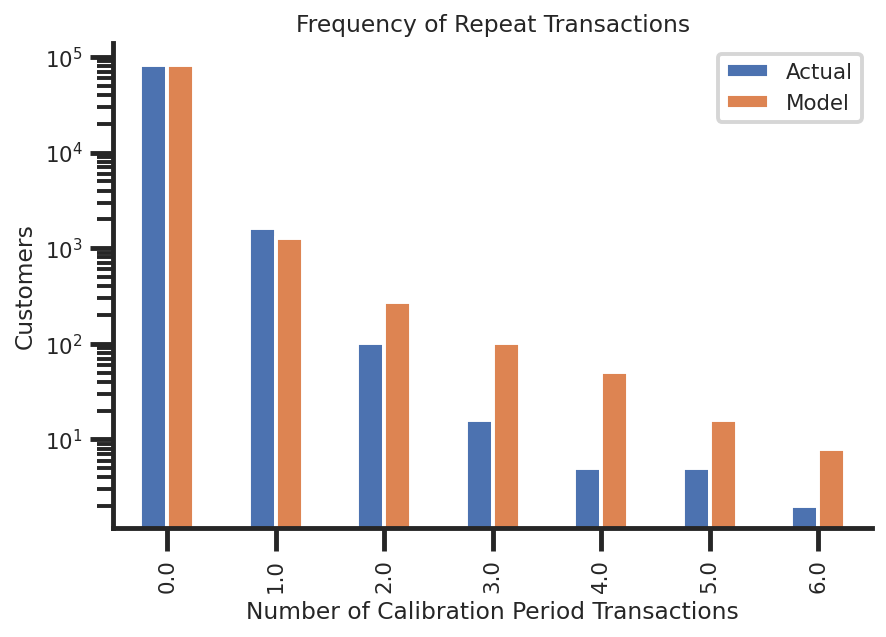

In [14]:
%%time

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

CPU times: user 93.7 ms, sys: 11.9 ms, total: 106 ms
Wall time: 110 ms


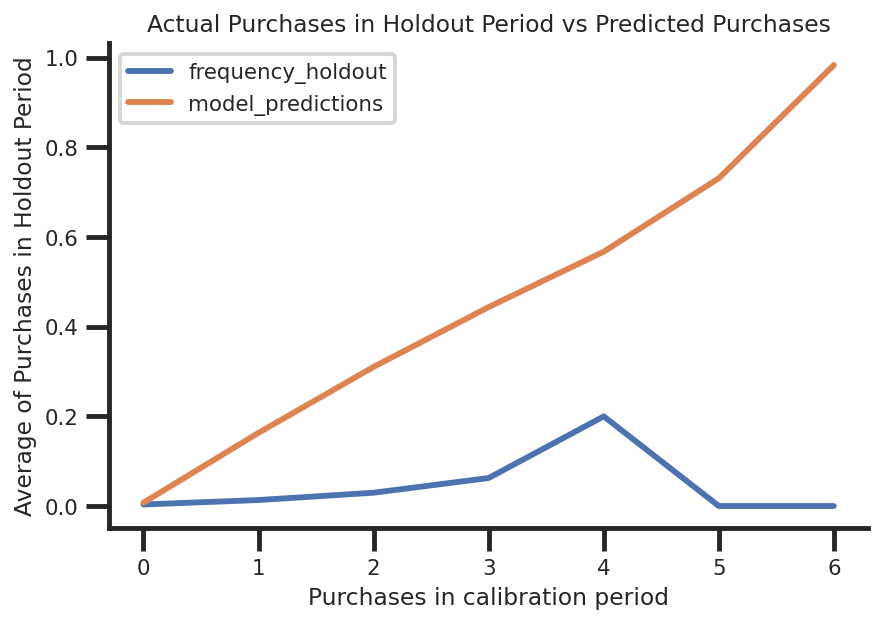

In [15]:
%%time

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();

In [18]:
elog.columns = ['CUSTOMER_ID', 'date']

In [19]:
%%time
# Get expected and actual repeated cumulative transactions.

from lifetimes.utils import expected_cumulative_transactions

t = (elog.date.max() - elog.date.min()).days
df = expected_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t)

CPU times: user 3.5 s, sys: 42.5 ms, total: 3.54 s
Wall time: 3.55 s


In [20]:
df.tail()

,actual,predicted
768,2383,3875.186570
769,2383,3888.104262
770,2383,3901.016511
771,2383,3913.923334
772,2384,3926.824743


CPU times: user 3.18 s, sys: 60.6 ms, total: 3.24 s
Wall time: 3.2 s


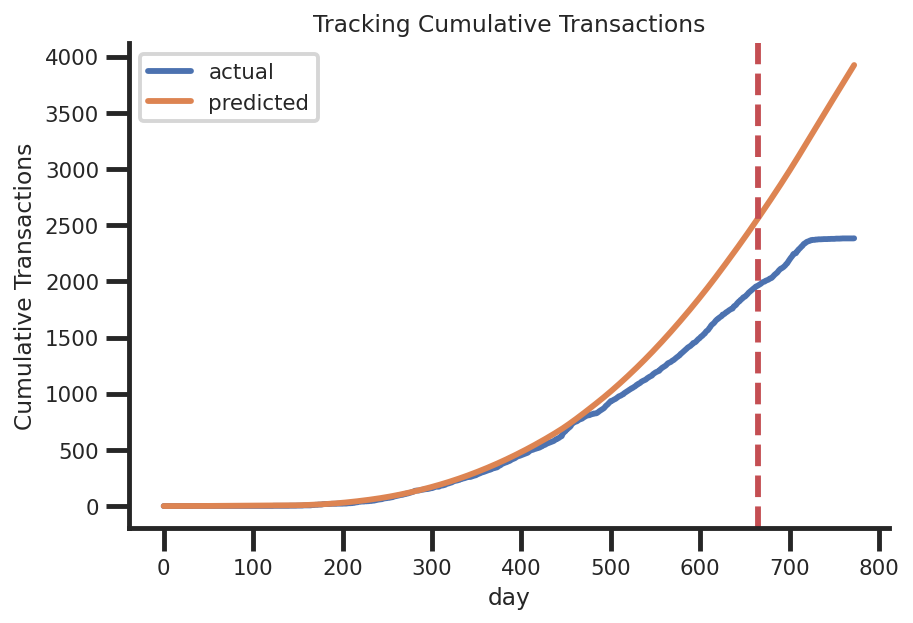

In [21]:
%%time
# Calibration period = 2016-09-04 to 2017-09-30
from datetime import datetime

cal = datetime.strptime('2018-06-30', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t = (elog.date.max() - elog.date.min()).days
t_cal = (cal - elog.date.min()).days
plot_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()

CPU times: user 3.45 s, sys: 47.4 ms, total: 3.5 s
Wall time: 3.48 s


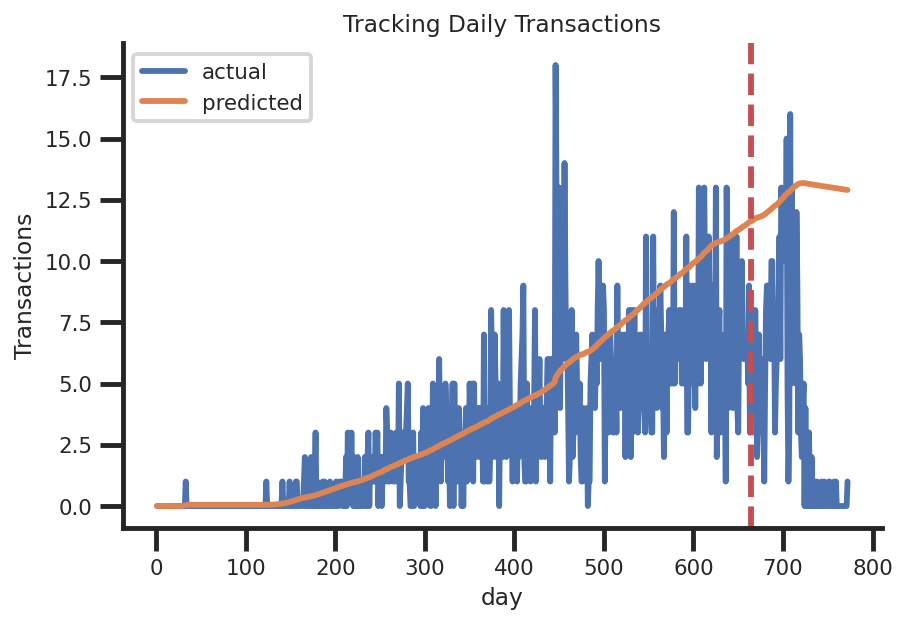

In [22]:
%%time

from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()